In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df=pd.read_csv('kc_house_data-Copy1.csv')

In [6]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
# Deleting column 0 - id
df.drop(['id'], axis=1, inplace=True)

# Data description

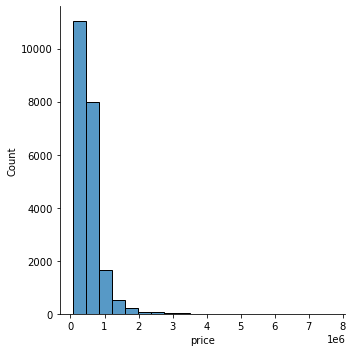

In [8]:
#1 price
sns.displot(df.price, bins=20)

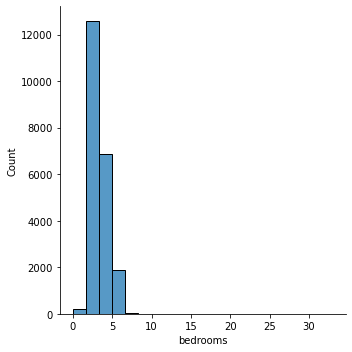

In [9]:
#2 bedrooms
sns.displot(df.bedrooms, bins=20)

In [12]:
df[df['bedrooms']>10]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,20140821T000000,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
15870,20140625T000000,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [13]:
print("column bedrooms:", set(df['bedrooms']))

column bedrooms: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33}


<AxesSubplot:xlabel='bedrooms', ylabel='price'>

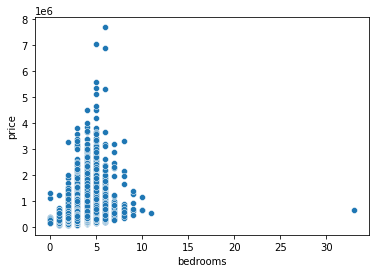

In [14]:
sns.scatterplot(x='bedrooms', y='price', data=df)

In [17]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [52]:
from numpy.lib.function_base import average
df.groupby('bedrooms').agg(
    {
        'price':[min, average, max],
        'sqft_living':[min, average, max],
        'bathrooms': [average]
    })

price                          sqft_living                      \
               min       average        max         min      average    max   
bedrooms                                                                      
1          75000.0  3.143150e+05  1247000.0         290   886.679612   3000   
2          78000.0  4.012965e+05  3278000.0         440  1240.748191   6840   
3          82000.0  4.662498e+05  3800000.0         490  1805.818321   6400   
4         100000.0  6.354195e+05  4489000.0         800  2554.649666   7850   
5         133000.0  7.865998e+05  7062500.0        1120  3047.545284  10040   
6         175000.0  8.255206e+05  7700000.0        1370  3284.341912  12050   
7         280000.0  9.633917e+05  3200000.0        1940  3972.350000  13540   
8         340000.0  1.105077e+06  3300000.0        2280  3800.000000   7710   
9         450000.0  8.939998e+05  1400000.0        2820  3775.000000   4620   
10        650000.0  8.193333e+05  1148000.0        2920  3706.666667   4590   
11        520000.0  5.200000e+05   520000.0        3000  3000.000000   3000   

         bathrooms  
           average  
bedrooms            
1         1.058252  
2         1.401501  
3         1.968372  
4         2.436428  
5         2.778576  
6         3.068015  
7         3.468750  
8         3.557692  
9         4.416667  
10        3.416667  
11        3.000000

In [20]:
# 33 bedrooms is a mistake, I'm changing it into 3:
df.loc[15870,'bedrooms']=3

In [23]:
df[df['bedrooms']==0].sort_values('price')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
14423,20150413T000000,139950.0,0,0.00,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,20140926T000000,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
4868,20141002T000000,228000.0,0,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000
9854,20141223T000000,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
8484,20140925T000000,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685
18379,20141029T000000,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3467,20140805T000000,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
12653,20150218T000000,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,1490,0,1999,0,98065,47.5261,-121.826,1500,4675
8477,20141117T000000,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
9773,20150429T000000,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050


In [38]:
# 0 bedrooms is a mistake, I'm changing it into 7 (where price > 1.000.000):
df["bedrooms"] = np.where( ((df["bedrooms"] == 0) & (df["price"] > 1000000)), 7, df["bedrooms"])
# changing into 2 (where price >= 320.000):
df["bedrooms"] = np.where( ((df["bedrooms"] == 0) & (df["price"] >= 320000)), 2, df["bedrooms"])
# changing into 1 (where price > 320.000):
df["bedrooms"] = np.where( ((df["bedrooms"] == 0) & (df["price"] < 320000)), 1, df["bedrooms"])

In [39]:
df['bedrooms'].value_counts()

3     9825
4     6882
2     2764
5     1601
6      272
1      206
7       40
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

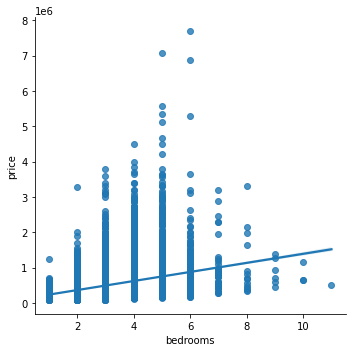

In [42]:
sns.lmplot(x='bedrooms', y='price', data=df)

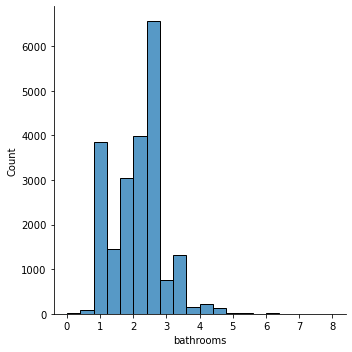

In [43]:
#2 bathrooms
sns.displot(df.bathrooms, bins=20)

In [44]:
df['bathrooms'].value_counts()

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [46]:
df[df['bathrooms']<0.5].sort_values('price')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1149,20150217T000000,75000.0,1,0.0,670,43377,1.0,0,0,3,3,670,0,1966,0,98022,47.2638,-121.906,1160,42882
14423,20150413T000000,139950.0,1,0.0,844,4269,1.0,0,0,4,7,844,0,1913,0,98001,47.2781,-122.250,1380,9600
19452,20140926T000000,142000.0,1,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
9854,20141223T000000,235000.0,1,0.0,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
5832,20141104T000000,280000.0,1,0.0,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549
9773,20150429T000000,355000.0,2,0.0,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
3119,20150205T000000,380000.0,2,0.0,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
10481,20140918T000000,484000.0,1,0.0,690,23244,1.0,0,0,4,7,690,0,1948,0,98053,47.6429,-121.955,1690,19290
875,20140612T000000,1095000.0,7,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
6994,20140624T000000,1295650.0,7,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061


In [47]:
df.groupby('bathrooms').agg(
    {
        'price':[min, average, max],
        'sqft_living':[min, average, max]
    })

price                          sqft_living                     
                 min       average        max         min       average    max
bathrooms                                                                     
0.00         75000.0  4.481600e+05  1295650.0         290   1636.800000   4810
0.50        109000.0  2.373750e+05   312500.0         580   1235.000000   2300
0.75         80000.0  2.945209e+05   785000.0         370    896.611111   2510
1.00         78000.0  3.470412e+05  1300000.0         390   1181.123313   3410
1.25        275000.0  6.212167e+05  1388000.0         860   1525.555556   2400
1.50        107000.0  4.093222e+05  1500000.0         680   1544.630014   3520
1.75        115000.0  4.548961e+05  3278000.0         590   1787.202428   6840
2.00        115000.0  4.578897e+05  2200000.0         720   1796.669430   5461
2.25        160000.0  5.336768e+05  2400000.0         850   2097.700537   4910
2.50        153503.0  5.535965e+05  3070000.0         750   2377.901115   5760
2.75        183750.0  6.602304e+05  2700000.0         730   2669.998312   5700
3.00        154000.0  7.084152e+05  4489000.0        1160   2736.035857   6430
3.25        176000.0  9.703398e+05  3640900.0        1210   3223.940577   7420
3.50        216650.0  9.319331e+05  3710000.0        1130   3411.303694   7350
3.75        255000.0  1.197217e+06  3650000.0        1580   3779.741935   7620
4.00        265000.0  1.267709e+06  3400000.0        1390   4071.867647   7850
4.25        490000.0  1.525774e+06  3850000.0        1960   4609.329114   6980
4.50        290000.0  1.333620e+06  7062500.0        2120   4405.940000  10040
4.75        480000.0  2.021304e+06  3650000.0        3700   5275.652174   7880
5.00        343000.0  1.673492e+06  5350000.0        2732   4851.857143   8000
5.25        300000.0  1.817177e+06  5110800.0        2860   5016.153846   8010
5.50        925000.0  2.522300e+06  4500000.0        5060   6506.000000   7400
5.75        540000.0  2.492500e+06  5570000.0        3700   6962.500000   9200
6.00        900000.0  2.946833e+06  5300000.0        4340   6443.333333   7440
6.25       2888000.0  3.094000e+06  3300000.0        8020   8345.000000   8670
6.50       1180000.0  1.709445e+06  2238890.0        6260   6765.000000   7270
6.75        800000.0  2.734000e+06  4668000.0        7480   8560.000000   9640
7.50        450000.0  4.500000e+05   450000.0        4050   4050.000000   4050
7.75       6885000.0  6.885000e+06  6885000.0        9890   9890.000000   9890
8.00       2280000.0  4.990000e+06  7700000.0       12050  12795.000000  13540

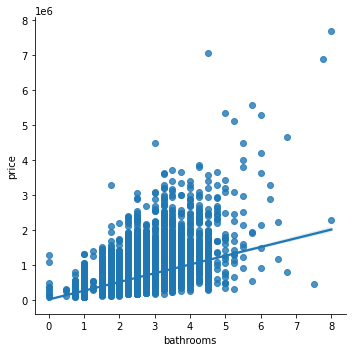

In [48]:
sns.lmplot(x='bathrooms', y='price', data=df)

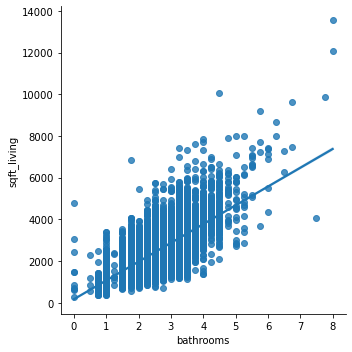

In [50]:
sns.lmplot(x='bathrooms', y='sqft_living', data=df)

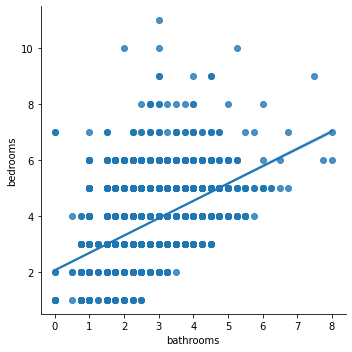

In [51]:
sns.lmplot(x='bathrooms', y='bedrooms', data=df)

In [53]:
avg_bath = df['sqft_living'] / df['bathrooms']
avg_bath

0        1180.000000
1        1142.222222
2         770.000000
3         653.333333
4         840.000000
            ...     
21608     612.000000
21609     924.000000
21610    1360.000000
21611     640.000000
21612    1360.000000
Length: 21613, dtype: float64

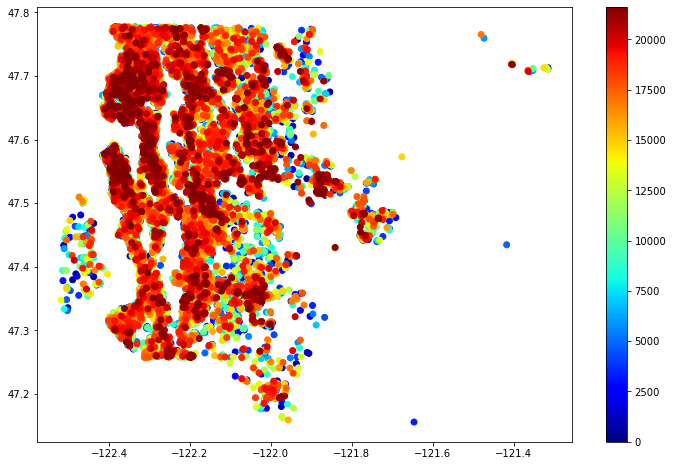

In [10]:
#16-17 longittude, lattitude
fig, ax=plt.subplots(figsize=(12,8))
sc=ax.scatter(df['long'], df['lat'], c=df['price'].index, cmap=plt.get_cmap('jet'))
plt.colorbar(sc)
plt.show()